In [1]:
import numpy as np
import pandas as pd
import datetime
import os

from DP_LSTM import *
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using TensorFlow backend.


In [2]:
data_pd = pd.read_csv(r'/home/wells/SIOA/DowJonesPredict/SourceData/DowJones.csv')
data_pd = data_pd.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'],axis=1)
data_pd['Date'] = pd.to_datetime(data_pd['Date'],format='%Y-%m-%d')


data_pd = data_pd.sort_index(ascending=False)
data_pd = data_pd.reset_index(drop=True)

In [3]:
data_pd.head()

,Date,Open
0,2008-08-08,11432.089844
1,2008-08-11,11729.669922
2,2008-08-12,11781.700195
3,2008-08-13,11632.809570
4,2008-08-14,11532.070312


In [4]:
# 总体上查看一下股指数据
def DrawExgRate(ExgRate_pd):
#     x = ExgRate_pd['DateTime']
    x = ExgRate_pd.Date  # [i for i in range(ExgRate_pd.shape[0])]
    plt.figure(figsize=(10,6), dpi=80)
    plt.subplot(1,1,1)
    plt.plot(x,ExgRate_pd['Open'],color='b',label='Dow Jons Price')
    # plt.plot(x,plot_pd['TrnsferPredict'],color='g',label='Transfer LSTM')
    plt.xlabel(r'Time Point')
    plt.ylabel(r'Price')
    plt.gcf().autofmt_xdate()
    plt.legend()
    #plt.savefig(r'D:\WORK__wells\GraduateProgram\Pics\USDAUD汇率.jpg')
    plt.show()

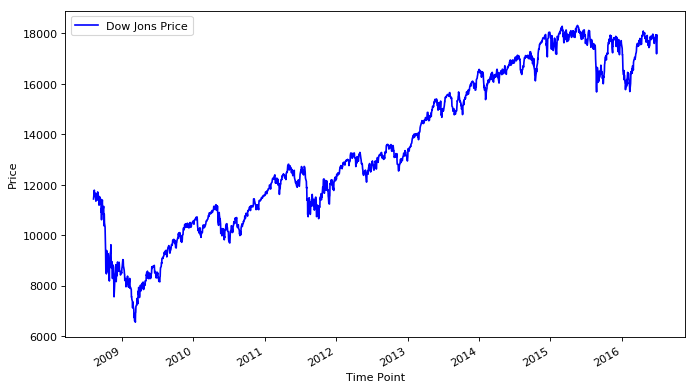

In [5]:
DrawExgRate(data_pd)

In [6]:
'''数据处理模块'''
#对实验数据进行归一化处理
def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    MMScaler = MinMaxScaler(feature_range=(0.1,1))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd['Open'].get_values(),(Raw_pd.Open.shape[0],1)))
    Raw_pd['OpenScaled'] = MMScaled_Data
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length):
        result.append(Normalized_pd.OpenScaled[index: index + sequence_length])
    result = np.array(result)
    return result

#  MMScaler.inverse_transform(np.reshape(Raw_pd.OpenScaled.get_values(), (Raw_pd.shape[0],1)))
def ShortTimePredict(ExgRate_pd, params,res_save_path=r'/home/wells/SIOA/DowJonesPredict\SourceCode\ResultSave'):
    #直观展示图
   # DrawExgRate(ExgRate_pd)
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    line_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE','RMSE_BP','MAE_BP','MAPE_BP','RMSE_SVR','MAE_SVR','MAPE_SVR'])
    # 对数据进行预处理
    Raw_pd,MMScaler = Raw_Data_Normalized(ExgRate_pd)
    print(r'处理数据:',Raw_pd.shape)
    # 构造时间序列数据
    TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
    # 划分训练测试集
    TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
    print(r'训练数据:',TrainSeries.shape)
    TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
    print(r'验证数据:',TestSeries.shape)
    TrainSeries_X = TrainSeries[:,:-1]
    TrainSeries_Y = TrainSeries[:,-1]
    TestSeries_X = TestSeries[:,:-1]
    TestSeries_Y = TestSeries[:,-1]
    # 张量化
    Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
    Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
    Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
    Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
    print(r'LSTM预测')
    LSTM_Model = build_LSTM_Model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_model = model_fit(LSTM_Model,Train_X, Train_Y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'])
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
    line_pd['RMSE'] = [RMSE]
    line_pd['MAE'] = [MAE]
    line_pd['MAPE'] = [MAPE]
    line_pd['TimeLags'] = [params['TimeLag']]
    print('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(RMSE,MAE,MAPE))
    
    result_pd = pd.concat([result_pd, line_pd])
    result_pd.to_csv(res_save_path + r'\LSTM直接预测结果.csv',index=None)
    return result_pd,Predict_y,True_Y

In [7]:
params = {
          'Timescale':1,
          'lr': 0.0001,
          'nb_hidden_cell': [80,80,80],
          'epochs': 500,
          'batch_size': 50,
          'TimeLag': 7,
          'TrainTestSplit':0.8,
          }

处理数据: (1989, 3)
训练数据: (1585, 8)
验证数据: (396, 8)
LSTM预测
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1109 samples, validate on 476 samples
Epoch 1/500
1109/1109 [==============================] - 16s 14ms/step - loss: 0.2052 - mean_absolute_error: 0.4354 - mean_absolute_percentage_error: 98.9587 - val_loss: 0.6419 - val_mean_absolute_error: 0.7975 - val_mean_absolute_percentage_error: 98.2011
Epoch 2/500
1109/1109 [==============================] - 1s 543us/step - loss: 0.1933 - mean_absolute_error: 0.4218 - mean_absolute_percentage_error: 95.5889 - val_loss: 0.6138 - val_mean_absolute_error: 0.7798 - val_mean_absolute_percentage_error: 96.0030
Epoch 3/500
1109/1109 [==============================] - 1s 455us/step - loss: 0.1795 - mean_absolute_error: 0.4058 - mean_absolute_percentage_error: 91.6860 - val_loss: 0.5775 - val_mean_absolute_error: 0.7563 - val_mean_absolute_percentage_error: 93.0931
Epoch 4/

1109/1109 [==============================] - 1s 526us/step - loss: 5.0946e-04 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 5.2621 - val_loss: 0.0023 - val_mean_absolute_error: 0.0408 - val_mean_absolute_percentage_error: 4.8462
Epoch 62/500
1109/1109 [==============================] - 1s 507us/step - loss: 4.9949e-04 - mean_absolute_error: 0.0162 - mean_absolute_percentage_error: 5.2027 - val_loss: 0.0024 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 5.0443
Epoch 63/500
1109/1109 [==============================] - 1s 528us/step - loss: 4.9028e-04 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 5.1464 - val_loss: 0.0026 - val_mean_absolute_error: 0.0440 - val_mean_absolute_percentage_error: 5.2364
Epoch 64/500
1109/1109 [==============================] - 1s 538us/step - loss: 4.8180e-04 - mean_absolute_error: 0.0160 - mean_absolute_percentage_error: 5.0927 - val_loss: 0.0028 - val_mean_absolute_error: 0.0456 - val_mean_absolut

1109/1109 [==============================] - 0s 445us/step - loss: 4.1055e-04 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 4.5261 - val_loss: 0.0053 - val_mean_absolute_error: 0.0656 - val_mean_absolute_percentage_error: 7.8349
Epoch 124/500
1109/1109 [==============================] - 1s 543us/step - loss: 4.1051e-04 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 4.5256 - val_loss: 0.0053 - val_mean_absolute_error: 0.0654 - val_mean_absolute_percentage_error: 7.8118
Epoch 125/500
1109/1109 [==============================] - 1s 559us/step - loss: 4.1046e-04 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 4.5250 - val_loss: 0.0052 - val_mean_absolute_error: 0.0652 - val_mean_absolute_percentage_error: 7.7883
Epoch 126/500
1109/1109 [==============================] - 1s 544us/step - loss: 4.1040e-04 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 4.5244 - val_loss: 0.0052 - val_mean_absolute_error: 0.0650 - val_mean_abso

1109/1109 [==============================] - 1s 525us/step - loss: 3.9534e-04 - mean_absolute_error: 0.0155 - mean_absolute_percentage_error: 4.4119 - val_loss: 0.0033 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 6.2015
Epoch 186/500
1109/1109 [==============================] - 1s 554us/step - loss: 3.9489e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 4.4087 - val_loss: 0.0033 - val_mean_absolute_error: 0.0516 - val_mean_absolute_percentage_error: 6.1744
Epoch 187/500
1109/1109 [==============================] - 1s 579us/step - loss: 3.9444e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 4.4054 - val_loss: 0.0033 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 6.1473
Epoch 188/500
1109/1109 [==============================] - 1s 500us/step - loss: 3.9398e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 4.4020 - val_loss: 0.0032 - val_mean_absolute_error: 0.0511 - val_mean_abso

1109/1109 [==============================] - 1s 500us/step - loss: 3.6127e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 4.1642 - val_loss: 0.0018 - val_mean_absolute_error: 0.0379 - val_mean_absolute_percentage_error: 4.5477
Epoch 248/500
1109/1109 [==============================] - 1s 540us/step - loss: 3.6064e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 4.1598 - val_loss: 0.0018 - val_mean_absolute_error: 0.0377 - val_mean_absolute_percentage_error: 4.5214
Epoch 249/500
1109/1109 [==============================] - 1s 517us/step - loss: 3.6003e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 4.1554 - val_loss: 0.0018 - val_mean_absolute_error: 0.0375 - val_mean_absolute_percentage_error: 4.4952
Epoch 250/500
1109/1109 [==============================] - 1s 549us/step - loss: 3.5941e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 4.1511 - val_loss: 0.0018 - val_mean_absolute_error: 0.0372 - val_mean_abso

1109/1109 [==============================] - 1s 536us/step - loss: 3.2242e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 3.8875 - val_loss: 8.3245e-04 - val_mean_absolute_error: 0.0247 - val_mean_absolute_percentage_error: 2.9773
Epoch 310/500
1109/1109 [==============================] - 1s 525us/step - loss: 3.2180e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 3.8831 - val_loss: 8.2028e-04 - val_mean_absolute_error: 0.0245 - val_mean_absolute_percentage_error: 2.9534
Epoch 311/500
1109/1109 [==============================] - 1s 546us/step - loss: 3.2118e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 3.8787 - val_loss: 8.0823e-04 - val_mean_absolute_error: 0.0243 - val_mean_absolute_percentage_error: 2.9296
Epoch 312/500
1109/1109 [==============================] - 1s 545us/step - loss: 3.2057e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 3.8744 - val_loss: 7.9632e-04 - val_mean_absolute_error: 0.0241

Epoch 340/500
1109/1109 [==============================] - 1s 534us/step - loss: 3.0365e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 3.7544 - val_loss: 5.0989e-04 - val_mean_absolute_error: 0.0187 - val_mean_absolute_percentage_error: 2.2684
Epoch 341/500
1109/1109 [==============================] - 1s 542us/step - loss: 3.0306e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 3.7502 - val_loss: 5.0129e-04 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 2.2470
Epoch 342/500
1109/1109 [==============================] - 1s 518us/step - loss: 3.0247e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 3.7460 - val_loss: 4.9285e-04 - val_mean_absolute_error: 0.0183 - val_mean_absolute_percentage_error: 2.2258
Epoch 343/500
1109/1109 [==============================] - 1s 544us/step - loss: 3.0188e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 3.7418 - val_loss: 4.8447e-04 - val_mean_absolute

Epoch 371/500
1109/1109 [==============================] - 1s 528us/step - loss: 2.8590e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 3.6291 - val_loss: 2.9295e-04 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 1.6597
Epoch 372/500
1109/1109 [==============================] - 1s 559us/step - loss: 2.8534e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 3.6252 - val_loss: 2.8758e-04 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 1.6423
Epoch 373/500
1109/1109 [==============================] - 1s 562us/step - loss: 2.8479e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 3.6213 - val_loss: 2.8228e-04 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 1.6251
Epoch 374/500
1109/1109 [==============================] - 1s 544us/step - loss: 2.8424e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 3.6174 - val_loss: 2.7712e-04 - val_mean_absolute

Epoch 402/500
1109/1109 [==============================] - 1s 533us/step - loss: 2.6924e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 3.5093 - val_loss: 1.6862e-04 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 1.2019
Epoch 403/500
1109/1109 [==============================] - 1s 556us/step - loss: 2.6871e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 3.5055 - val_loss: 1.6598e-04 - val_mean_absolute_error: 0.0096 - val_mean_absolute_percentage_error: 1.1908
Epoch 404/500
1109/1109 [==============================] - 1s 506us/step - loss: 2.6820e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 3.5017 - val_loss: 1.6341e-04 - val_mean_absolute_error: 0.0095 - val_mean_absolute_percentage_error: 1.1800
Epoch 405/500
1109/1109 [==============================] - 1s 527us/step - loss: 2.6768e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 3.4979 - val_loss: 1.6094e-04 - val_mean_absolute

Epoch 433/500
1109/1109 [==============================] - 1s 528us/step - loss: 2.5357e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 3.3928 - val_loss: 1.2115e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 1.0365
Epoch 434/500
1109/1109 [==============================] - 1s 541us/step - loss: 2.5308e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 3.3891 - val_loss: 1.2070e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 1.0369
Epoch 435/500
1109/1109 [==============================] - 1s 543us/step - loss: 2.5259e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 3.3855 - val_loss: 1.2030e-04 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 1.0375
Epoch 436/500
1109/1109 [==============================] - 1s 578us/step - loss: 2.5210e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 3.3819 - val_loss: 1.1997e-04 - val_mean_absolute

Epoch 464/500
1109/1109 [==============================] - 1s 517us/step - loss: 2.3868e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 3.2807 - val_loss: 1.3197e-04 - val_mean_absolute_error: 0.0094 - val_mean_absolute_percentage_error: 1.1459
Epoch 465/500
1109/1109 [==============================] - 1s 516us/step - loss: 2.3820e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 3.2771 - val_loss: 1.3305e-04 - val_mean_absolute_error: 0.0094 - val_mean_absolute_percentage_error: 1.1523
Epoch 466/500
1109/1109 [==============================] - 1s 524us/step - loss: 2.3773e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 3.2734 - val_loss: 1.3417e-04 - val_mean_absolute_error: 0.0095 - val_mean_absolute_percentage_error: 1.1588
Epoch 467/500
1109/1109 [==============================] - 1s 523us/step - loss: 2.3726e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 3.2699 - val_loss: 1.3532e-04 - val_mean_absolute

Epoch 495/500
1109/1109 [==============================] - 0s 215us/step - loss: 2.2409e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 3.1676 - val_loss: 1.7808e-04 - val_mean_absolute_error: 0.0112 - val_mean_absolute_percentage_error: 1.3551
Epoch 496/500
1109/1109 [==============================] - 0s 216us/step - loss: 2.2362e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 3.1638 - val_loss: 1.7982e-04 - val_mean_absolute_error: 0.0113 - val_mean_absolute_percentage_error: 1.3618
Epoch 497/500
1109/1109 [==============================] - 0s 211us/step - loss: 2.2315e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 3.1600 - val_loss: 1.8155e-04 - val_mean_absolute_error: 0.0113 - val_mean_absolute_percentage_error: 1.3683
Epoch 498/500
1109/1109 [==============================] - 0s 232us/step - loss: 2.2267e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 3.1562 - val_loss: 1.8329e-04 - val_mean_absolute

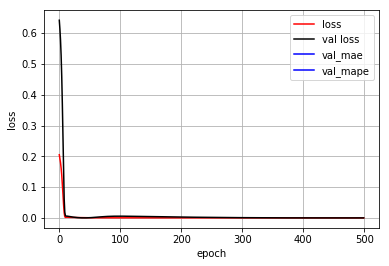

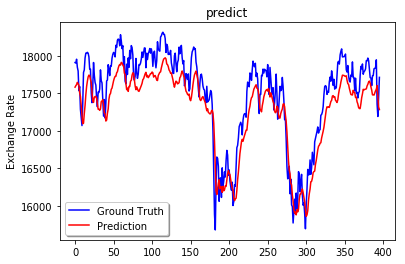

RMSE:299.77186824215084  ,MAE:262.93794140435614  ,MAPE:1.499983938339244 
RMSE:299.77186824215084  ,MAE:262.93794140435614  ,MAPE:1.499983938339244 


In [8]:
result_pd,Predict_y,True_Y = ShortTimePredict(data_pd.iloc[:,:], params)